In [1]:
import logging
import time
from cv2 import (
    findContours,
    contourArea,
    threshold,
    THRESH_BINARY,
    RETR_TREE,
    CHAIN_APPROX_SIMPLE,
    minEnclosingCircle, 
    minAreaRect,
    THRESH_TOZERO,
    circle,
    COLOR_BGR2GRAY,
    cvtColor,
    morphologyEx,
    MORPH_CLOSE
    )
import cv2
from fractions import Fraction
from decimal import Decimal
import numpy as np
from math import pi
from typing import TYPE_CHECKING

LOGGER = logging.getLogger(__name__)

ECCENTRICITY_CRITERIA = 0.7
IS_CONTOUR_EMPTY_CRITERIA = 0.4

R_25_um = 10/2048
R_75_um = 30/2048

R_TH_100um = 44/2048
R_TH_200um = 80/2048
R_300_um = 100/2048

R_TH = R_TH_200um
ALGO_TIMEOUT_IN_SECONDS = 0.05


def extract_gray_map_from_red_channel(image):
    b = image[:,:,0]
    r = image[:,:,2]
    red_channel = r >= b

    gray_level_img = cvtColor(image, COLOR_BGR2GRAY)

    out_img = red_channel*gray_level_img

    out_img = out_img.astype(np.uint8)
    return out_img

class ConnectedComponents:
    def __init__(self):
        self.area_list = []
        self.centroid_list = []
        self.minor_axis_list = []
        self.major_axis_list = []
        self.radius_list = []
        self.contour = []

    def get_properties_connected_component(self, binary_image):
        try:
            _, contours, _ = findContours(
                binary_image, RETR_TREE, CHAIN_APPROX_SIMPLE)
        except:
            contours, _ = findContours(
                binary_image, RETR_TREE, CHAIN_APPROX_SIMPLE)
        
        for cntr in contours:
            if len(cntr) > 4:
                area = contourArea(cntr)
                if int(area) > 15:
                    
                    center, radius = minEnclosingCircle(cntr)
                    
                    (_,_), (major_axis, minor_axis), _ = minAreaRect(cntr)

                    
                    self.centroid_list.append(center)
                    self.radius_list.append(radius)
                    area = pi * radius * radius
                    self.area_list.append(area)
                    self.major_axis_list.append(minor_axis / 2)
                    self.minor_axis_list.append(major_axis / 2)
                    self.contour.append(cntr)
    
def analyze_binary_image_for_rosa(binary_image):

    in_img_size = binary_image.shape

    cc = ConnectedComponents()
    cc.get_properties_connected_component(binary_image)
    if len(cc.area_list) >= 15:
        return False, 0, 0, 0

    t = time.time()
    list_idx = np.flip(np.argsort(cc.area_list), 0)

    if len(cc.area_list) > 0:
        area_number = len(cc.area_list)
        if area_number > 1:
            LOGGER.debug("Multiple areas:" + str(area_number))
        for idx in list_idx:
            circle_centroid = cc.centroid_list[idx]
            circle_radius = cc.radius_list[idx]
            if int(circle_radius) > int(R_75_um * in_img_size[0]) and int(circle_radius) <= int(R_300_um * in_img_size[0]):
                minor_axis = np.min([cc.minor_axis_list[idx], cc.major_axis_list[idx]])
                major_axis = np.max([cc.minor_axis_list[idx], cc.major_axis_list[idx]])
                is_a_circle = minor_axis/major_axis > ECCENTRICITY_CRITERIA
                if is_a_circle:
                    return True, float(circle_centroid[1]), float(circle_centroid[0]), float(circle_radius)
    return False, 0, 0, 0
    

def format_blob(in_image, laser_spot_parameter):
    captor_ratio = 1.18
    c_h, c_w, radius, found = laser_spot_parameter
    h, w = in_image.shape[0], in_image.shape[1]

    rectangle_height = min(h,w)
    rectangle_width = max(h,w)

    r, c = c_w, c_h

    radius = int(radius)
    blob = {
        'center': {
            "x": r / rectangle_width,
            "y": c / rectangle_height,
            "rx": r,
            "ry": c},
        'radius': float(
            Fraction(
                Fraction(
                    Decimal(radius)),
                h)),
        'rradius': radius,
        'found': found}
    return blob


def format_image(in_image: np.ndarray) -> np.ndarray:
    out_image = np.array(in_image, dtype=np.uint8)
    return out_image

def fine_tune_rosa_detection(red_channel, c_h, c_w, radius):
    h, w = np.shape(red_channel)
    c_h, c_w = int(c_h), int(c_w)

    c_h_orig, c_w_orig = int(c_h), int(c_w)
    original_radius = int(radius)

    h_crop = h/8
    w_crop = w/8
    h_min = np.amax([int(c_h-h_crop), 0])
    h_max = np.amin([int(c_h+h_crop), h])
    
    w_min = np.amax([int(c_w-w_crop), 0])
    w_max = np.amin([int(c_w+w_crop), h])

    crop_img = red_channel[h_min:h_max, w_min:w_max]

    new_img = np.zeros((h,w))
    new_img[h_min:h_max, w_min:w_max] = crop_img
    perc = int(np.max([np.percentile(crop_img, 95) - 1, 0]))

    in_img_size = red_channel.shape
    if int(perc) == 0:
        return c_h, c_w, original_radius
 
    else:
        _, binary_image = threshold(new_img, int(perc), 255, THRESH_BINARY)

        binary_image = binary_image.astype(np.uint8)
        found, c_h, c_w, radius = analyze_binary_image_for_rosa(binary_image)
        if found:
            return c_h, c_w, radius
        else:
            return c_h_orig, c_w_orig, original_radius
    return c_h_orig, c_w_orig, original_radius


def find_laser_spot_main_call(in_image: np.ndarray):
    formatted_image = format_image(in_image)

    time_start = time.time()
    red_channel = extract_gray_map_from_red_channel(formatted_image)
    max_value_red_channel = np.max(red_channel)
 
    found, rec_time, c_h, c_w, radius = find_laser_spot_recursive(
        red_channel, 0.95, max_value_red_channel, time_start, 0)

    if found:
        c_h, c_w, fine_tuned_radius = fine_tune_rosa_detection(red_channel, c_h, c_w, radius)
        radius = fine_tuned_radius

    blob = format_blob(in_image, [c_h, c_w, radius, found])
    time_elapsed = (time.time() - time_start)

    laser_found = "Laser found" if found else "Laser NOT found"

    LOGGER.warning(
        str.format(
            "{0}. Took {1}. Recursive count {2}",
            laser_found,
            str(time_elapsed),
            str(rec_time)))

    return blob, rec_time, found


def find_laser_spot_recursive(red_channel, thr, max_value, start_time, rec_time):
    rec_time = rec_time + 1

    binary_image = binarize_laser_image(red_channel, thr, max_value)

    current_time = time.time() - start_time
    if current_time > ALGO_TIMEOUT_IN_SECONDS:
        LOGGER.warning(
            str.format(
                "Laser spot not found - too long: Took {0} for {1} iteration.",
                str(current_time),
                rec_time))
        return False, rec_time, 0, 0, 0

    if thr < 0.4:
        LOGGER.debug(
            str.format(
                "Laser spot not found after {0} iteration in {1}",
                rec_time,
                str(current_time)))
        return False, rec_time, 0, 0, 0

    found, c_h, c_w, circle_radius = analyze_binary_image_for_rosa(binary_image)
    if found:
        return True, rec_time, c_h, c_w, circle_radius
    
    else:
        th = thr - 0.1
        return find_laser_spot_recursive(red_channel, th, max_value, start_time, rec_time)


def binarize_laser_image(input_image, thresh, max_value):
    gray_image = input_image
    max = max_value

    half_range = 3
    retval, binary_image = threshold(
        gray_image, int(max * thresh)-half_range, 255, THRESH_TOZERO)
    retval, binary_image = threshold(
        binary_image, int(max * thresh)+half_range, 255, THRESH_BINARY)
    

    return binary_image


# if __name__ == "__main__":
def mainRosa(image_path):
    import matplotlib.pyplot as plt
    import os
#     path = os.path.abspath(os.getcwd())
#     image_path = os.path.join(path, 'eye5-92-3097_laser.jpeg')
    # image_path = os.path.join(path, 'eye1-39-2521_laser.jpeg')
#     image_path='./2222/002.jpg'

    image = cv2.imread(image_path)
    image_size = image.shape

    blob, rec_time, found = find_laser_spot_main_call(image)
    
#     center = (int(blob['center']['x']*image_size[1]), int(blob['center']['y']*image_size[0]))
#     radius = int(blob['radius']*image_size[0])
#     cv2.circle(image, center, radius, (255,0,0), 2)

#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.imshow(image_rgb)
#     plt.show()


    return blob

    #the find_laser_spot function takes a bgr image as input, won't work if you give rgb image


Laser found. Took 0.08114194869995117. Recursive count 3


2
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/002.jpg
2
4
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/004.jpg


Laser found. Took 0.051145076751708984. Recursive count 2


4
6
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/006.jpg


Laser found. Took 0.05626797676086426. Recursive count 2


6
8
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/008.jpg


Laser found. Took 0.07513427734375. Recursive count 3


8
10
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/010.jpg


Laser found. Took 0.06019425392150879. Recursive count 3


10
12
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/012.jpg


Laser found. Took 0.053460121154785156. Recursive count 2


12
14
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/014.jpg


Laser found. Took 0.05213165283203125. Recursive count 2


14
16
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/016.jpg


Laser found. Took 0.059046268463134766. Recursive count 3


16
18
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/018.jpg


Laser found. Took 0.05094408988952637. Recursive count 2


18
20
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/020.jpg


Laser found. Took 0.055639028549194336. Recursive count 2


20
22
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/022.jpg


Laser found. Took 0.053726911544799805. Recursive count 2


22


Laser found. Took 0.05301403999328613. Recursive count 3


24
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/024.jpg
24


Laser found. Took 0.05102086067199707. Recursive count 2


26
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/026.jpg
26


Laser found. Took 0.04606175422668457. Recursive count 2


28
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/028.jpg
28


Laser found. Took 0.04822897911071777. Recursive count 2


30
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/030.jpg
30


Laser found. Took 0.05205225944519043. Recursive count 2


32
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/032.jpg
32


Laser found. Took 0.0859990119934082. Recursive count 3


34
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/034.jpg
34


Laser found. Took 0.07502412796020508. Recursive count 2


36
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/036.jpg
36


Laser found. Took 0.061856985092163086. Recursive count 2


38
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/038.jpg
38


Laser found. Took 0.06686186790466309. Recursive count 3


40
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/040.jpg


Laser found. Took 0.04425621032714844. Recursive count 2


40
42
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/042.jpg


Laser found. Took 0.06339287757873535. Recursive count 2


42
44
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/044.jpg
44
46
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/046.jpg


Laser found. Took 0.07536983489990234. Recursive count 2


46


Laser found. Took 0.045868873596191406. Recursive count 2


48
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/048.jpg
48
50
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/050.jpg


Laser found. Took 0.1026310920715332. Recursive count 3


50
52
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/052.jpg


Laser found. Took 0.10845088958740234. Recursive count 2


52


Laser found. Took 0.06445693969726562. Recursive count 3


54
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/054.jpg
54


Laser spot not found - too long: Took 0.06211996078491211 for 3 iteration.
Laser NOT found. Took 0.06771373748779297. Recursive count 3


56
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/056.jpg


Laser found. Took 0.056741952896118164. Recursive count 4


58
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/058.jpg
58
60
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/060.jpg


Laser found. Took 0.10257172584533691. Recursive count 3


60
62
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/062.jpg


Laser found. Took 0.07004404067993164. Recursive count 3


62
64
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/064.jpg


Laser found. Took 0.05349302291870117. Recursive count 2


64
66
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/066.jpg


Laser found. Took 0.07979702949523926. Recursive count 2


66
68
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/068.jpg


Laser found. Took 0.054208993911743164. Recursive count 2


68
70
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/070.jpg


Laser found. Took 0.08489704132080078. Recursive count 2


70


Laser found. Took 0.058075904846191406. Recursive count 3


72
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/072.jpg
72


Laser found. Took 0.07778191566467285. Recursive count 2


74
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/074.jpg
74


Laser found. Took 0.0471649169921875. Recursive count 2


76
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/076.jpg
76


Laser found. Took 0.07135510444641113. Recursive count 2


78
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/078.jpg
78


Laser found. Took 0.051299095153808594. Recursive count 2


80
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/080.jpg
80


Laser found. Took 0.06748795509338379. Recursive count 2


82
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/082.jpg
82


Laser found. Took 0.049722909927368164. Recursive count 2


84
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/084.jpg
84


Laser found. Took 0.04617595672607422. Recursive count 2


86
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/086.jpg
86


Laser found. Took 0.05409717559814453. Recursive count 3


88
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/088.jpg
88


Laser found. Took 0.05285906791687012. Recursive count 3


90
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/090.jpg
90


Laser found. Took 0.048132896423339844. Recursive count 2


92
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/092.jpg
92


Laser found. Took 0.05455327033996582. Recursive count 3


94
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/094.jpg
94


Laser found. Took 0.046376943588256836. Recursive count 2


96
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/096.jpg
96


Laser found. Took 0.055069923400878906. Recursive count 2


98
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/098.jpg
98


Laser found. Took 0.04740619659423828. Recursive count 2


100
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/100.jpg
100


Laser found. Took 0.07611894607543945. Recursive count 2


102
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/102.jpg
102


Laser found. Took 0.04736804962158203. Recursive count 2


104
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/104.jpg
104


Laser found. Took 0.056880950927734375. Recursive count 2


106
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/106.jpg
106


Laser found. Took 0.0734410285949707. Recursive count 2


108
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/108.jpg
108
110
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/110.jpg


Laser found. Took 0.1214439868927002. Recursive count 2


110
112
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/112.jpg


Laser found. Took 0.10879826545715332. Recursive count 4


112
114
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/114.jpg


Laser found. Took 0.10061001777648926. Recursive count 4


114


Laser spot not found - too long: Took 0.05107998847961426 for 4 iteration.
Laser NOT found. Took 0.05696606636047363. Recursive count 4


116
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/116.jpg


Laser spot not found - too long: Took 0.06736183166503906 for 7 iteration.
Laser NOT found. Took 0.07046890258789062. Recursive count 7


118
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/118.jpg


Laser spot not found - too long: Took 0.05881500244140625 for 5 iteration.
Laser NOT found. Took 0.0625150203704834. Recursive count 5


120
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/120.jpg


Laser spot not found - too long: Took 0.06887292861938477 for 7 iteration.
Laser NOT found. Took 0.07165884971618652. Recursive count 7


122
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/122.jpg


Laser spot not found - too long: Took 0.05643296241760254 for 6 iteration.
Laser NOT found. Took 0.0590207576751709. Recursive count 6


124
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/124.jpg


Laser spot not found - too long: Took 0.058287858963012695 for 7 iteration.
Laser NOT found. Took 0.06109285354614258. Recursive count 7


126
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/126.jpg
128
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/128.jpg


Laser found. Took 0.10498309135437012. Recursive count 4


128


Laser found. Took 0.06766676902770996. Recursive count 4


130
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/130.jpg
130


Laser spot not found - too long: Took 0.0601801872253418 for 6 iteration.
Laser NOT found. Took 0.062409162521362305. Recursive count 6


132
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/132.jpg


Laser spot not found - too long: Took 0.056488037109375 for 6 iteration.
Laser NOT found. Took 0.0597529411315918. Recursive count 6


134
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/134.jpg


Laser spot not found - too long: Took 0.07857108116149902 for 6 iteration.
Laser NOT found. Took 0.08072185516357422. Recursive count 6


136
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/136.jpg


Laser found. Took 0.08943700790405273. Recursive count 4


138
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/138.jpg
138


Laser spot not found - too long: Took 0.050238847732543945 for 5 iteration.
Laser NOT found. Took 0.05253291130065918. Recursive count 5


140
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/140.jpg


Laser spot not found - too long: Took 0.07451915740966797 for 6 iteration.
Laser NOT found. Took 0.07634615898132324. Recursive count 6


142
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/142.jpg


Laser spot not found - too long: Took 0.10412907600402832 for 6 iteration.
Laser NOT found. Took 0.10601806640625. Recursive count 6


144
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/144.jpg
146
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/146.jpg


Laser spot not found - too long: Took 0.1562190055847168 for 7 iteration.
Laser NOT found. Took 0.15914702415466309. Recursive count 7
Laser spot not found - too long: Took 0.08494901657104492 for 6 iteration.
Laser NOT found. Took 0.08729290962219238. Recursive count 6


148
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/148.jpg


Laser NOT found. Took 0.04919886589050293. Recursive count 7


150
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/150.jpg


Laser found. Took 0.09686684608459473. Recursive count 5


152
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/152.jpg
152


Laser found. Took 0.08718085289001465. Recursive count 5


154
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/154.jpg
154
156
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/156.jpg


Laser spot not found - too long: Took 0.1903841495513916 for 7 iteration.
Laser NOT found. Took 0.1939239501953125. Recursive count 7
Laser spot not found - too long: Took 0.07502388954162598 for 7 iteration.
Laser NOT found. Took 0.07768774032592773. Recursive count 7


158
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/158.jpg


Laser spot not found - too long: Took 0.05828976631164551 for 5 iteration.
Laser NOT found. Took 0.061228036880493164. Recursive count 5


160
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/160.jpg


Laser found. Took 0.07884073257446289. Recursive count 4


162
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/162.jpg
162


Laser spot not found - too long: Took 0.05271291732788086 for 7 iteration.
Laser NOT found. Took 0.05549001693725586. Recursive count 7


164
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/164.jpg


Laser NOT found. Took 0.05181002616882324. Recursive count 7


166
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/166.jpg


Laser NOT found. Took 0.04767775535583496. Recursive count 7


168
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/168.jpg


Laser NOT found. Took 0.0497589111328125. Recursive count 7


170
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/170.jpg


Laser spot not found - too long: Took 0.057832956314086914 for 3 iteration.
Laser NOT found. Took 0.06023001670837402. Recursive count 3


172
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/172.jpg


Laser NOT found. Took 0.049758195877075195. Recursive count 7


174
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/174.jpg


Laser NOT found. Took 0.05025815963745117. Recursive count 7


176
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/176.jpg


Laser spot not found - too long: Took 0.05240297317504883 for 7 iteration.
Laser NOT found. Took 0.055143117904663086. Recursive count 7


178
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/178.jpg


Laser spot not found - too long: Took 0.05307602882385254 for 7 iteration.
Laser NOT found. Took 0.05590415000915527. Recursive count 7


180
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/180.jpg


Laser NOT found. Took 0.051672935485839844. Recursive count 7


182
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/182.jpg


Laser spot not found - too long: Took 0.050308942794799805 for 5 iteration.
Laser NOT found. Took 0.054077863693237305. Recursive count 5


184
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/184.jpg


Laser spot not found - too long: Took 0.05268597602844238 for 6 iteration.
Laser NOT found. Took 0.056363821029663086. Recursive count 6


186
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/186.jpg


Laser spot not found - too long: Took 0.050717830657958984 for 6 iteration.
Laser NOT found. Took 0.05404400825500488. Recursive count 6


188
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/188.jpg


Laser spot not found - too long: Took 0.05085492134094238 for 6 iteration.
Laser NOT found. Took 0.054647207260131836. Recursive count 6


190
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/190.jpg


Laser spot not found - too long: Took 0.051328182220458984 for 7 iteration.
Laser NOT found. Took 0.05434012413024902. Recursive count 7


192
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/192.jpg


Laser found. Took 0.09203886985778809. Recursive count 5


194
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/194.jpg
194


Laser found. Took 0.11326193809509277. Recursive count 3


196
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/196.jpg
196


Laser found. Took 0.07122802734375. Recursive count 4


198
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/198.jpg
198


Laser found. Took 0.08699798583984375. Recursive count 5


200
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/200.jpg
200


Laser found. Took 0.07220602035522461. Recursive count 5


202
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/202.jpg
202


Laser spot not found - too long: Took 0.07050919532775879 for 6 iteration.
Laser NOT found. Took 0.07286310195922852. Recursive count 6


204
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/204.jpg


Laser found. Took 0.07940387725830078. Recursive count 3


206
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/206.jpg
206


Laser found. Took 0.08794188499450684. Recursive count 4


208
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/208.jpg
208


Laser found. Took 0.09296989440917969. Recursive count 3


210
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/210.jpg
210


Laser found. Took 0.08797502517700195. Recursive count 2


212
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/212.jpg
212


Laser found. Took 0.0616610050201416. Recursive count 2


214
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/214.jpg
214


Laser found. Took 0.056488037109375. Recursive count 2


216
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/216.jpg
216


Laser found. Took 0.05530595779418945. Recursive count 2


218
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/218.jpg
218
220
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/220.jpg


Laser found. Took 0.0711979866027832. Recursive count 2


220


Laser found. Took 0.09383511543273926. Recursive count 3


222
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/222.jpg
222


Laser found. Took 0.06146359443664551. Recursive count 3


224
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/224.jpg
224


Laser found. Took 0.050219058990478516. Recursive count 2


226
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/226.jpg
226


Laser found. Took 0.06571793556213379. Recursive count 2


228
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/228.jpg
228
(80, 2048, 2448)
(80, 2048, 2448)
(79,)
(79,)
(79,)


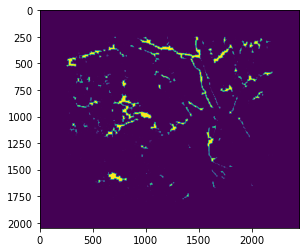

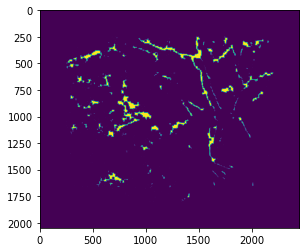

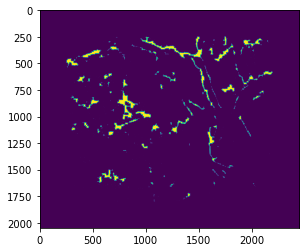

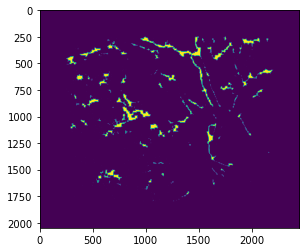

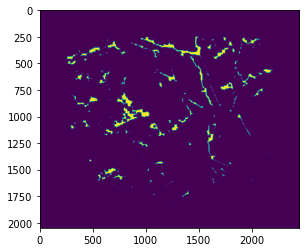

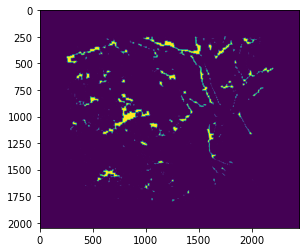

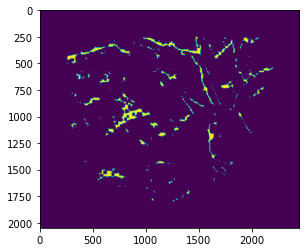

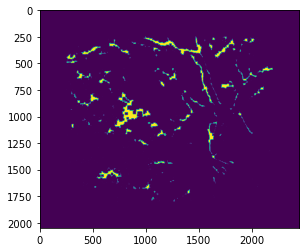

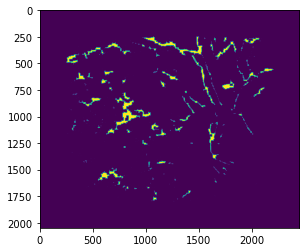

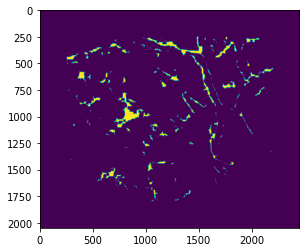

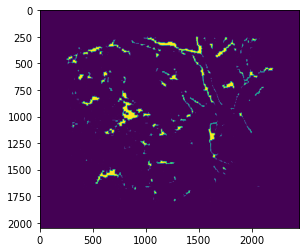

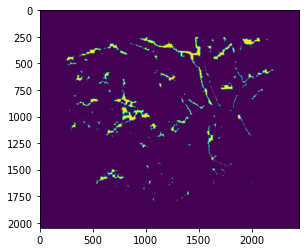

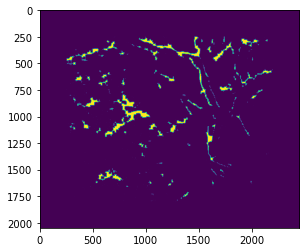

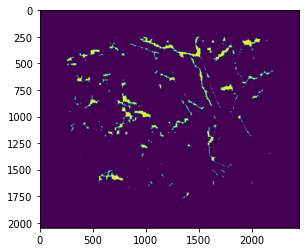

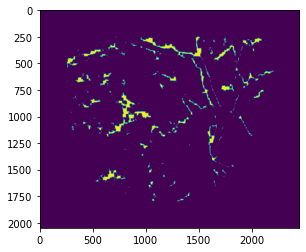

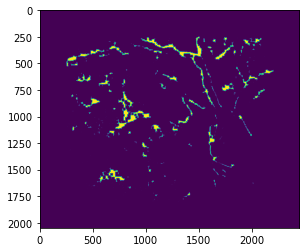

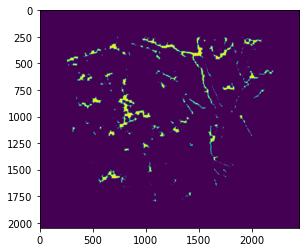

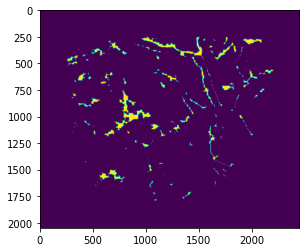

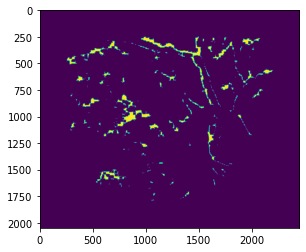

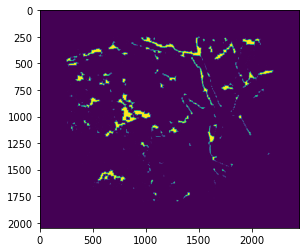

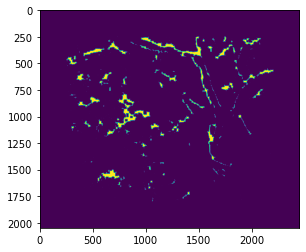

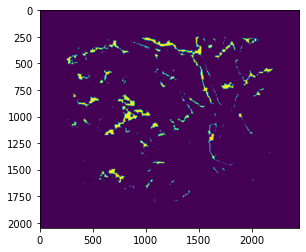

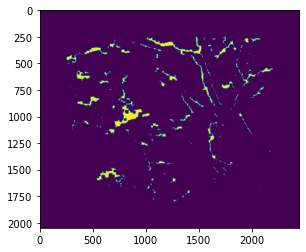

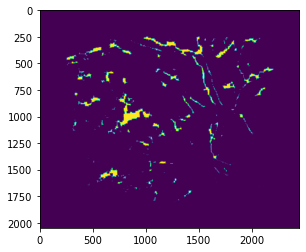

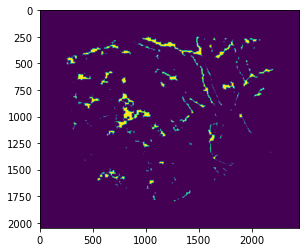

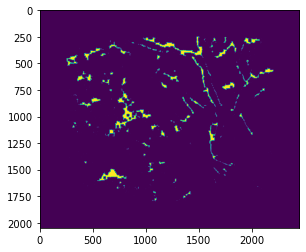

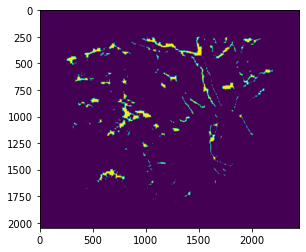

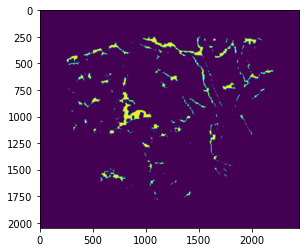

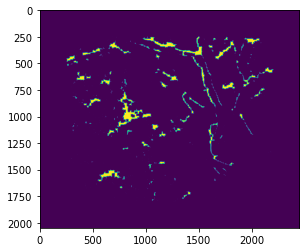

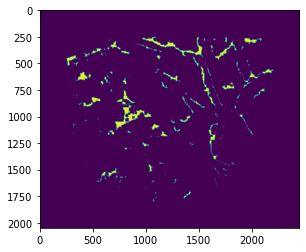

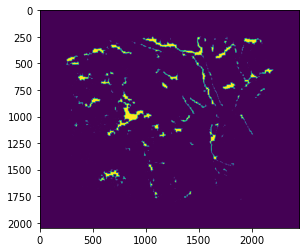

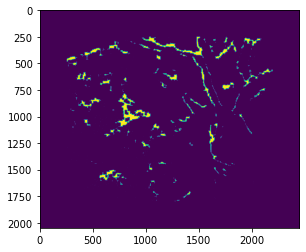

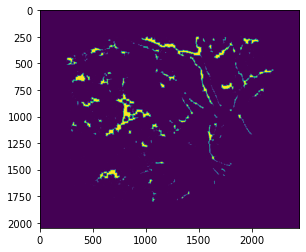

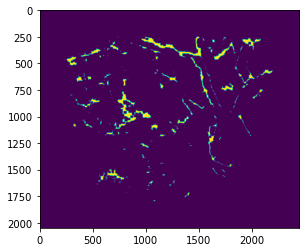

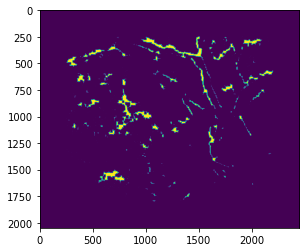

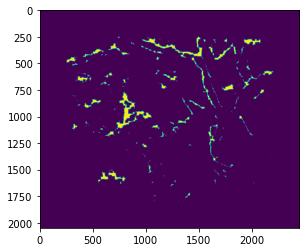

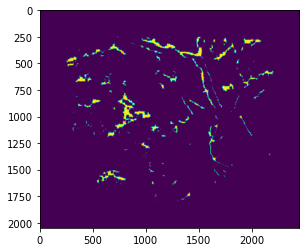

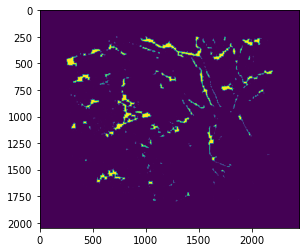

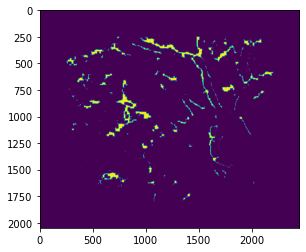

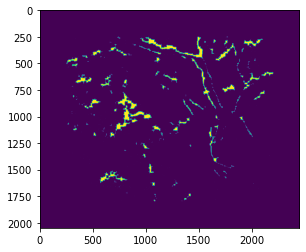

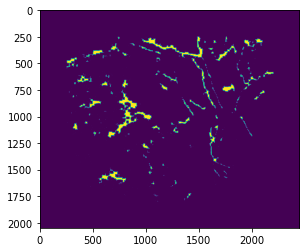

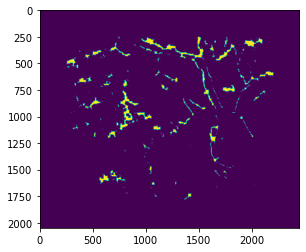

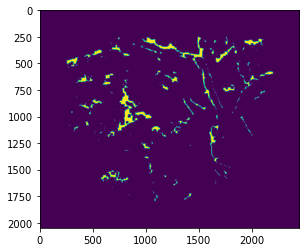

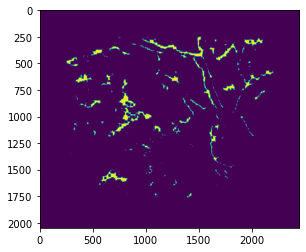

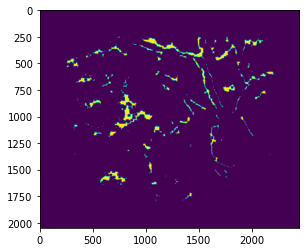

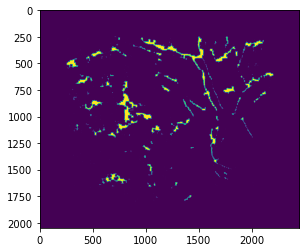

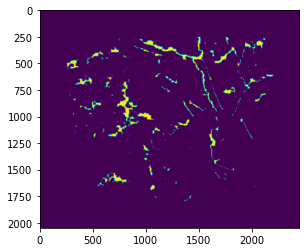

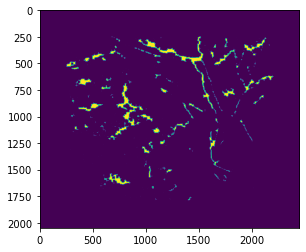

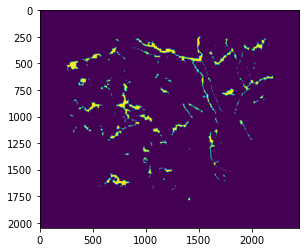

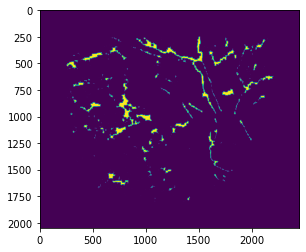

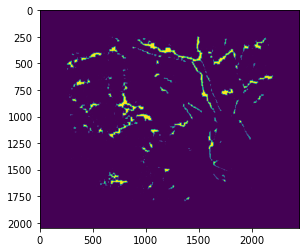

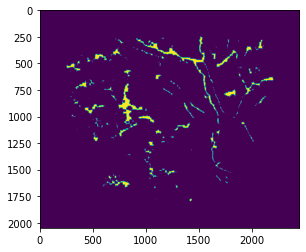

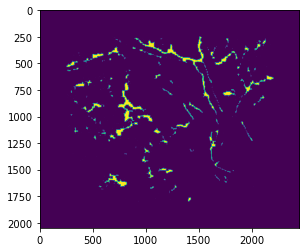

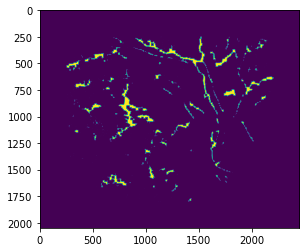

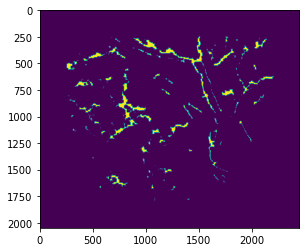

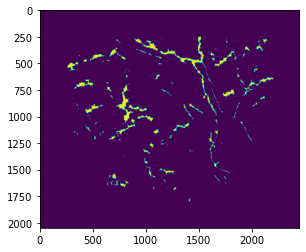

In [2]:
from skimage.io import imread_collection
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fftpack as fp
from matplotlib import pyplot
from scipy.signal import find_peaks
from scipy import ndimage
import scipy.signal

def loadImages(collectionDir):
    collectionDir=collectionDir+'*.jpg'
    imageCollection = imread_collection(collectionDir)
    grayImage=np.zeros((len(imageCollection),imageCollection[0].shape[0],imageCollection[0].shape[1]))
    for i in range(len(imageCollection)):
        imageCollection[i][:,:,2]=0
        grayImage[i,:,:]=rgb2gray(imageCollection[i])
    return grayImage
        

def intensityCheck(Image,laser,xLaser,yLaser,rLaser):
    index=np.array([])
    ii=np.array([])
    for kk in range(Image.shape[0]):
        d1=Image[kk,:,:]
        d1=256*((d1-np.min(d1))/(np.max(d1)-np.min(d1)))
        resLap = cv2.Laplacian(d1, cv2.CV_64F)
        score = resLap.var()
        ii=np.hstack((ii,score))
    T=np.mean(ii)
    index=np.where(ii>T)
    Image=np.delete(Image,index,axis=0)
    laser=np.delete(laser,index,axis=0)
    xLaser=np.delete(xLaser,index,axis=0)
    yLaser=np.delete(yLaser,index,axis=0)
    rLaser=np.delete(rLaser,index,axis=0)
    return Image,laser,xLaser,yLaser,rLaser



def seperateImages(grayImageCollection,collectionDir):
#     imageCollection = imread_collection(collectionDir)
    Thresh=np.mean(grayImageCollection)
    counter=0
    Image=np.empty((1,grayImageCollection.shape[1], grayImageCollection.shape[2]), float)
    laserImage=np.empty((1,grayImageCollection.shape[1], grayImageCollection.shape[2]), float)
    temp=np.empty((1,grayImage.shape[1], grayImageCollection.shape[2]), float)
    xCenter=np.array([])
    yCenter=np.array([])
    radius=np.array([])
    
    for i in range(1,grayImageCollection.shape[0]):
        if (np.mean(grayImageCollection[i-1,:,:])>Thresh and np.mean(grayImageCollection[i,:,:])<Thresh):
            print(i)
            if (i<10):
                loadLaserImage=collectionDir+'00'+str(i)+'.jpg'
            if (i>=9 and i<100):
                loadLaserImage=collectionDir+'0'+str(i)+'.jpg'
            if (i>=100):
                loadLaserImage=collectionDir+str(i)+'.jpg'
            print(loadLaserImage)
#             print(loadLaserImage.shape)
            blob=mainRosa(loadLaserImage)
            if (blob['found'] == True):
                temp[0,:,:]=grayImageCollection[i-1,:,:]
                Image=np.vstack((Image,temp))
                temp[0,:,:]=grayImageCollection[i,:,:]
                laserImage=np.vstack((laserImage,temp))
            
#             print(blob)
                print(i)
                xCenter=np.hstack((xCenter,int(blob['center']['x']*Image.shape[2])))
                yCenter=np.hstack((yCenter,int(blob['center']['y']*Image.shape[1])))
                radius=np.hstack((radius,int(blob['radius']*Image.shape[1])))
                
#     enter = (int(blob['center']['x']*image_size[1]), int(blob['center']['y']*image_size[0]))
#     radius = int(blob['radius']*image_size[0])        
            
    print(Image.shape)
    print(laserImage.shape)
    print(xCenter.shape)
    print(yCenter.shape)
    print(radius.shape)
    Image=np.delete(Image,0,axis=0)
    laserImage=np.delete(laserImage,0,axis=0)
#     print(Image.shape)
#     print(laserImage.shape)
    return Image,laserImage,xCenter,yCenter,radius



def cross_image(im1, im2):
   # get rid of the color channels by performing a grayscale transform
   # the type cast into 'float' is to avoid overflows
   # get rid of the averages, otherwise the results are not good
   im1 -= np.mean(im1)
   im2 -= np.mean(im2)
   # calculate the correlation image; note the flipping of onw of the images
   return scipy.signal.fftconvolve(im1, im2[::-1,::-1], mode='same')

def ImageShift(Image):
    Margin=250
    N=100
    temp=Image[:,Margin:Image.shape[1]-Margin,Margin:Image.shape[2]-Margin]
    skeletonImage=np.zeros(Image.shape)
    a=np.zeros(Image.shape)
    indexShift=np.array([0,0])
    totalShift=np.array([0,0])
    for j in range(temp.shape[0]):
        for i in range(temp.shape[1]):
            y=np.convolve(temp[j,i,:], np.ones(N)/N, mode='valid')
            peaks, properties = find_peaks(-y,prominence=0.001,distance=250)
            skeletonImage[j,i+Margin,peaks+Margin]=1
        for i in range(temp.shape[2]):
            y=np.convolve(temp[j,:,i], np.ones(N)/N, mode='valid')
            peaks, properties = find_peaks(-y,prominence=0.001,distance=250)
            skeletonImage[j,peaks+Margin,i+Margin]=1

        a[j,:,:]=ndimage.binary_closing(skeletonImage[j,:,:], structure=np.ones((20,20))).astype(np.int)
        
        plt.imshow(a[j,:,:])
        plt.show()


        if (j>0):
            out1=cross_image(a[j-1,:,:],a[j,:,:])
            ind= np.unravel_index(np.argmax(out1, axis=None), out1.shape)
            indexShift=np.vstack((indexShift,np.array(ind)-np.array([a.shape[1]/2,a.shape[2]/2])))
            totalShift=np.vstack((totalShift,np.sum(indexShift,axis=0)))
    return totalShift



            

# collectionDir = './zilia/20200228_140744_singe2/*.jpg'
# collectionDir = './1111/*.jpg'
# collectionDir = './2222/*.jpg'
# collectionDir='./2222/'
# collectionDir = './zilia/singe2/20200229_084156_singe2_scanRetine_day2/*.jpg'
# collectionDir = './zilia/Singe3/oeilDroit_singe3/20200229_090916_spectro180_RLP20/*.jpg'
# collectionDir = './zilia/Singe1/20200228_134918_/*.jpg'
# collectionDir = './zilia/Singe1/20200229_081046_Scan_singe1_day2/*.jpg'
# collectionDir = './zilia/Singe2/20200229_084156_singe2_scanRetine_day2/*.jpg'
# collectionDir = './zilia/singe26/oeilDroit_singe26/20200303_100701_psr/*.jpg'
collectionDir = './zilia/singe26/oeilDroit_singe26/20200303_100701_psr/'

grayImage=np.array([])
Image=np.array([])
laser=np.array([])
xLaser=np.array([])
yLaser=np.array([])
rLaser=np.array([])

grayImage=loadImages(collectionDir)
Image,laser,xLaser,yLaser,rLaser=seperateImages(grayImage,collectionDir)   
Image,laser,xLaser,yLaser,rLaser=intensityCheck(Image,laser,xLaser,yLaser,rLaser)
indexShift=ImageShift(Image)

for j in range(Image.shape[0]):
    window_name = 'Image'  
    center_coordinates = (1000-int(indexShift[j,1]),1000-int(indexShift[j,0]))
    radius = 30
    # Blue color in BGR
    color = (0, 255, 0)
    # Line thickness of 2 px
    thickness = 5
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    image = cv2.circle(Image[j,:,:], center_coordinates, radius, color, thickness)
    pyplot.imsave(str(2*j)+'.jpg',image)
    
    window_name = 'Image'  
    center_coordinates = (int(xLaser[j]),int(yLaser[j]))
    radius = int(rLaser[j])
    # Blue color in BGR
    color = (0, 0, 255)
    # Line thickness of 2 px
    thickness = 5
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    image = cv2.circle(laser[j,:,:], center_coordinates, radius, color, thickness)
    pyplot.imsave(str(2*j+1)+'.jpg',image)





In [ ]:
### Referencce Image
# from skimage.io import imread
# import imutils


# def skeleton(inputImage):
#     Margin=250
#     N=100
#     temp=inputImage[Margin:inputImage.shape[0]-Margin,Margin:inputImage.shape[1]-Margin]
#     outputImage=np.zeros(inputImage.shape)
#     for i in range(temp.shape[0]):
#         y=np.convolve(temp[i,:], np.ones(N)/N, mode='valid')
#         peaks, properties = find_peaks(-y, prominence=0.001,distance=250,)
#         outputImage[i+Margin,peaks+Margin]=1
#     for i in range(temp.shape[1]):
#         y=np.convolve(temp[:,i], np.ones(N)/N, mode='valid')
#         peaks, properties = find_peaks(-y,prominence=0.001, distance=250)
#         outputImage[peaks+Margin,i+Margin]=1    
#     outputImage=ndimage.binary_closing(outputImage, structure=np.ones((20,20))).astype(np.int)
#     return outputImage
    

# refDir='./Ref.jpg'
# refImage= imread(refDir) #load ref image
# refImage[:,:,2]=0 #blue channel=0
# grayRef = rgb2gray(refImage)


# skeletonRef=skeleton(grayRef)
# skeletonRef=skeletonRef.astype(np.float64)

# theta=np.arange(0,360,2)
# stack=np.empty((1,skeletonRef.shape[0], skeletonRef.shape[1]), float)
# temp=np.empty((1,skeletonRef.shape[0], skeletonRef.shape[1]), float)
# for j in range (Image.shape[0]):
#     for i in range (theta.shape[0]):
#         rot = imutils.rotate(skeleton(Image[j,:,:]).astype(np.float32), angle=theta[i])
#         rot=rot.astype(np.float64)
# #         cv2.imshow("Rotated (Problematic)", rot)
# #         cv2.waitKey(0)
#         temp[0,:,:]= cross_image(skeletonRef,rot)
#         stack=np.vstack((stack,temp))
#         stack=np.delete(stack,0,axis=0)
# ind= np.unravel_index(np.argmax(stack, axis=None), stack.shape)
# print(ind)
        
        

        
        
        
                        
            
    
# # #     a=np.zeros(Image.shape)
# # #     indexShift=np.array([0,0])
# # #     totalShift=np.array([0,0])
# # #     for j in range(temp.shape[0]):
# # #         for i in range(temp.shape[1]):
            
            
# # #         for i in range(temp.shape[2]):
# # #             y=np.convolve(temp[j,:,i], np.ones(N)/N, mode='valid')
# # #             peaks, properties = find_peaks(-y,distance=250,prominence=0.001)
# # #             skeletonImage[j,peaks+Margin,i+Margin]=1

# # #         a[j,:,:]=ndimage.binary_closing(skeletonImage[j,:,:], structure=np.ones((20,20))).astype(np.int)

# # #         if (j>0):
# # #             out1=cross_image(a[j-1,:,:],a[j,:,:])
# # #             ind= np.unravel_index(np.argmax(out1, axis=None), out1.shape)

In [44]:
print(temp[0,336,1227])

1.0


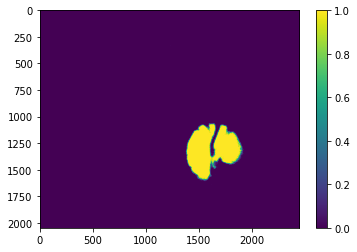

520
515
1330
1636
360


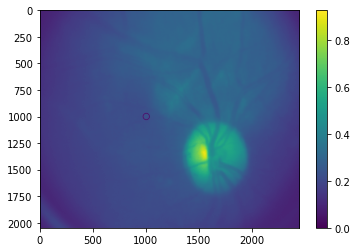

In [52]:
temp=np.zeros(Image.shape)
temp[np.where(Image>=np.mean(Image)*2)]=1
plt.imshow(temp[0,:,:])
plt.colorbar()
plt.show()

kernel = np.ones((5,5),np.uint8)
openingTemp = cv2.morphologyEx(temp[0,:,:], cv2.MORPH_OPEN, kernel)

nonZero=np.nonzero(openingTemp)
upToDown=np.max(nonZero[0])-np.min(nonZero[0])
upToDownCenter=int((np.max(nonZero[0])+np.min(nonZero[0]))/2)
rightToLeft=np.max(nonZero[1])-np.min(nonZero[1])
rightToLeftCenter=int((np.max(nonZero[1])+np.min(nonZero[1]))/2)
length=int((np.max([upToDown,rightToLeft])+200)/2)

square=Image[0,np.min([0,upToDownCenter]):,:]



plt.imshow(Image[0,:,:])
plt.colorbar()
plt.show()



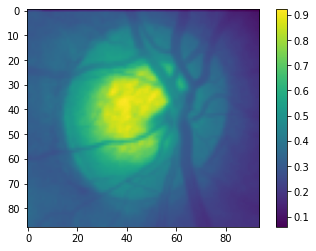

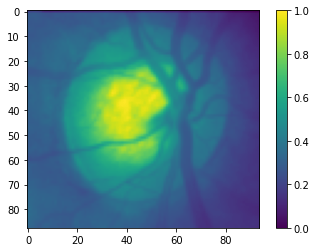

In [33]:
Ref=cv2.imread('RefImage.png')
grayRef=rgb2gray(Ref)

plt.imshow(grayRef)
plt.colorbar()
plt.show()

plt.imshow((grayRef-np.min(grayRef))/(np.max(grayRef)-np.min(grayRef)))
plt.colorbar()
plt.show()

# Reftemp=np.zeros(grayRef.shape)
# Reftemp[np.where(grayRef>=np.mean(grayRef)*2.2)]=1
# plt.imshow(Reftemp)
# plt.colorbar()
# plt.show()

In [26]:
np.mean(grayRef)

0.18287735646197953